# Tripadvisor - Copenhagen restaurants

<br>
<font color='red'>
Intro to the project...

## Contents
* [1 Scraper info](#scraper)
* [2 The datasets and data preparation](#datasets)
    * [2.1 TripStoresInfo.csv](#tripstoresinfo)
    * [2.2 TripReviews.csv](#tripreviews)
    * [2.3 Shapefiles](#shapefiles)
* [3 Descriptive stats](#descStats)
    * [3.1 Restaurants](#restaurants)
    * [3.2 Reviews](#reviews)
* [4 Business questions](#businessquestions)

<hr>

The first step as always is to install and import the necessary packages.

In [42]:
#!pip install pandas_profiling
#!pip install folium

# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import ast
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
import requests
import urllib.parse
import folium
import geopandas as gpd
import json
from datetime import datetime

<a id='scraper'></a>
# 1. Scraper info

<a id="datasets"></a>
# 2. The datasets and data preparation
<font color='red'>
The scraper is run...
</font>

The data is saved into two files:
1. **TripStoresInfo.csv**: Contains information about each resturant.
1. **TripReviews.csv**: Contains the reviews for each restaurant.

The raw data is gathered from the csv files and cleaned and prepared for further analysis.

Additionally some datasets were downloaded from the internet. These include shapefiles of Denmark with municipality division.

<a id="tripstoresinfo"></a>
## 2.1 TripStoresInfo.csv

**TripStoresInfo.csv** containts information about each restaurant. Namely:
* Restaurant name
* Address
* Average rating
* Number of reviews
* Price category
* List of cousine types the restaurant offers
* Rank

Let's examine how the data looks by loading the **TripStoresInfo.csv** into a pandas dataframe.

In [16]:
# Load and examine the restaurant info dataset
# Know that CousineType contains a list, so use converter to get it read in correctly
restaurants = pd.read_csv('TripStoresInfo.csv', 
                          converters={'CousineType':ast.literal_eval})
restaurants.head()

,storeName,storeAddress,avgRating,nrReviews,priceCategory,CousineType,Rank
0,Maple Casual Dining,"Vesterbrogade 24, Copenhagen 1620 Denmark",5.0,237,$$ - $$$,"[International, European, Vegetarian Friendly]",#1
1,Keyser Social,"Frederiksborggade 20d, Copenhagen 1360 Denmark",5.0,125,$$$$,"[Asian, Thai, Vegetarian Friendly]",#2
2,Restaurant Krebsegaarden,"Studiestraede 17, Copenhagen 1455 Denmark",5.0,"1,403",$$$$,"[European, Scandinavian, Danish]",#3
3,The Olive Kitchen & Bar,"Noerregade 22, Copenhagen 1165 Denmark",5.0,"2,413",$$ - $$$,"[International, European, Gluten Free Options]",#4
4,Ark,"Noerre Farimagsgade 63, Copenhagen 1364 Denmark",5.0,277,$$ - $$$,"[European, Contemporary, Healthy]",#5


The **priceCategory** column appears to be displaying in a weird way. However when a single row is printed, the correct format of the column can be seen.

In [17]:
restaurants.iloc[0]

storeName                                   Maple Casual Dining
storeAddress          Vesterbrogade 24, Copenhagen 1620 Denmark
avgRating                                                     5
nrReviews                                                   237
priceCategory                                          $$ - $$$
CousineType      [International, European, Vegetarian Friendly]
Rank                                                         #1
Name: 0, dtype: object

A clean-up needs to be performed before the dataset is used for further analysis. Since '$$' is a keyword in Matplotlib, the **priceCategory** column has to be mapped to something. A mapping to integers was created, since they are a nice way to represent the data.

Additionally the **Rank** column is modified, in such a way that the '#' symbol is removed so the column can be converted from a string to integer. 

In [18]:
# Since the Pandas profiler can no display string with '$$' it is necessary to map the price categories differently
restaurants.priceCategory = restaurants.priceCategory.map({'$': 1, '$ - $$': 1.5, '$$': 2, '$$ - $$$': 2.5, '$$$': 3, '$$$ - $$$$': 3.5, '$$$$': 4, '$$$$ - $$$$$': 4.5, '$$$$$': 5})

# Remove the '#' in the front of the Rank column
restaurants.Rank = restaurants.Rank.apply(lambda x: x.replace('#','')).apply(lambda x: int(x))

Finally it would be benefitial to get the latitude and longitude coordinates of the restaurant address, so that it can easily be plotted on a map and used for further analysis. This can be achieved by using the address as a query string and calling the Open Street maps. Since some of the addresses are in a weird format, the name of the restaurant will first be used in the search query (with 'denmark' added at the end to clarify the search). If the location information can be found from the restaurant name, that will be used. If the location information can not be found from the name then the address will be used to generate the latitude and longitude.

In [19]:
# Iterate through all the rows of the dataset and gather the lat and lon info into vectors
# First we use the lat/lon info found from the restaurant name since that could be considered more accurate 
# since users have to label the restaurant on a map. Otherwise the info from the address is used.
# Finally we collect the display name, to be able to extract the municipality information

# Create vectors to store information
lats = []
lons = []
displayNames = []

for idx, row in restaurants.iterrows():
    
    lat = None
    lon = None
    displayName = None
    address = row.storeAddress
    name = row.storeName
    url1 = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(name + " denmark") +'?format=json'
    url2 = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(address) +'?format=json'

    # Make the first request based on the name
    response1 = requests.get(url1).json()
    
    if response1:
        lat = response1[0]["lat"]
        lon = response1[0]["lon"]
        displayName = response1[0]["display_name"]
    else:
        # make the second request based on the address
        response2 = requests.get(url2).json()
        if response2:
            lat = response2[0]["lat"]
            lon = response2[0]["lon"]
            displayName = response2[0]["display_name"]
    
    # Append the info we gathered into the vectors
    lats.append(lat)
    lons.append(lon)
    displayNames.append(displayName)
    
# Add the vectors to the dataset
restaurants['lat'] = lats
restaurants['lon'] = lons
restaurants['location'] = displayNames

After this data preparation the information about a single restaurant appears like so:

In [20]:
restaurants.iloc[0]

storeName                                      Maple Casual Dining
storeAddress             Vesterbrogade 24, Copenhagen 1620 Denmark
avgRating                                                        5
nrReviews                                                      237
priceCategory                                                  2.5
CousineType         [International, European, Vegetarian Friendly]
Rank                                                             1
lat                                                     55.6729579
lon                                                     12.5581383
location         Maple Casual Dining, Vesterbrogade, Kødbyen, V...
Name: 0, dtype: object

<a id="tripreviews"></a>
## 2.2 TripReviews.csv

**TripReviews.csv** containts information about each review for every restaurant. Namely:
* Restaurant name
* Reviewer's username
* Date of rating
* Header of review
* Review text
* User's rating

Let's examine how the data looks:

In [59]:
reviews = pd.read_csv('TripReviews.csv')
reviews.head()

,storeName,reviewerUsername,ratingDate,reviewHeader,reviewText,rating
0,Maple Casual Dining,918emmaf,"December 5, 2020",Exquisite,We visited Maple in Friday night and had a won...,5
1,Maple Casual Dining,hildurj2016,"November 19, 2020",Perfect wedding dinner,"Excellent food, drinks and service!! Me and my...",5
2,Maple Casual Dining,Judy B,"October 27, 2020",Beautifully Presented Food,I visited this restaurant on my first ever vis...,5
3,Maple Casual Dining,EldBjoern,"October 18, 2020",Very good food and very pleasant people,We ate dinner in their restaurant. The waiter ...,5
4,Maple Casual Dining,MacondoExpresss,"October 13, 2020",A lovely birthday dinner,Visited as a couple to celebrate my birthday. ...,5


The above dataset appears ready for use, however the **ratingDate** is presented as a string. 

In [60]:
print(reviews.iloc[0].ratingDate)
print(type(reviews.iloc[0].ratingDate))

December 5, 2020
<class 'str'>


For further analysis, it will be benefitial to have converted this column into a timestamp object.

In [61]:
reviews['ratingDate'] = reviews['ratingDate'].apply(lambda x: datetime.strptime(x, '%B %d, %Y'))
print(reviews.iloc[0].ratingDate)
print(type(reviews.iloc[0].ratingDate))

2020-12-05 00:00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


<a id="shapefiles"></a>
## 2.3 Shapefiles
Shapefiles for the whole of Denmark were downloaded from [here](https://www.diva-gis.org/datadown).
The files include information about the municipalities and their division within Denmark.
These can be used later on when performing analysis that require information about different areas of Denmark.

The first step is to load and examine the dataset

In [27]:
# Load the shapefiles and 
shp = 'DNK_adm/DNK_adm2.shp'
gdf = gpd.read_file(shp)

gdf.head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,TYPE_2,ENGTYPE_2,NL_NAME_2,VARNAME_2,geometry
0,64,DNK,Denmark,1,Hovedstaden,1,Albertslund,Kommune,Municipality,None,None,"POLYGON ((12.37129 55.66019, 12.36338 55.65877..."
1,64,DNK,Denmark,1,Hovedstaden,2,Allerød,Kommune,Municipality,None,None,"POLYGON ((12.20744 55.82782, 12.21004 55.83235..."
2,64,DNK,Denmark,1,Hovedstaden,3,Ballerup,Kommune,Municipality,None,None,"POLYGON ((12.42482 55.70868, 12.41010 55.70942..."
3,64,DNK,Denmark,1,Hovedstaden,4,Bornholm,Kommune,Municipality,None,None,"POLYGON ((14.88805 55.03042, 14.88805 55.03058..."
4,64,DNK,Denmark,1,Hovedstaden,5,Brøndby,Kommune,Municipality,None,None,"MULTIPOLYGON (((12.45293 55.66484, 12.45315 55..."


Any analysis performed will be focused on the capital region, so the shapefile is filtered on *Hovedstaden* and some of the included islands are skipped so the plot will be as clear as possible. Each municipality will be plotted in a seperate color based on their numerical ID in the shapefile.

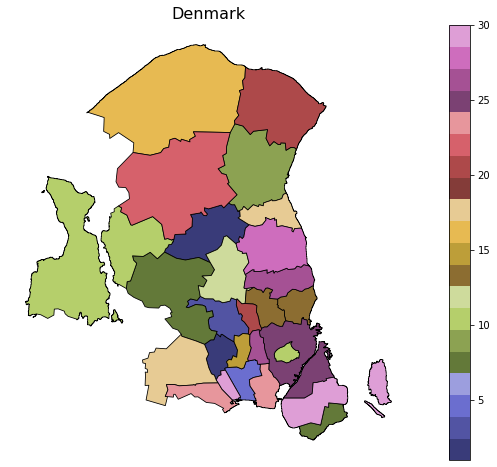

In [36]:
# Filter on the areas we want displayed
hovedstaden = gdf[(gdf.ID_1==1) & (gdf.NAME_2 != 'Bornholm') & (gdf.NAME_2 != 'Christiansø') & (gdf.NAME_2 != 'Halsnæs')]

# Plot the shapefiles
fig, ax = plt.subplots(1, figsize=(14, 8));
hovedstaden.plot(column='ID_2', cmap='tab20b', linewidth=0.8, ax=ax, edgecolor='black', legend=True);
ax.axis('off');
ax.set_title('Denmark', fontsize=16);

<a id="descStats"></a>
# 3. Descriptive stats
...

<a id="restaurants"></a>
## 3.1. Restaurants
...

In [8]:
# Generate a profile for the dataset and display it
restaurant_profile = ProfileReport(restaurants, title="Restaurants Info dataset", html={'style': {'full_width': True}});
restaurant_profile.to_notebook_iframe();

<font color='red'>**ADD DISCUSSION ON FINAL FINDINGS**</font>

From the profiler it can be seen that it does not handle a column containing a list. Therefore we do an additional check for the **CousineType** column.

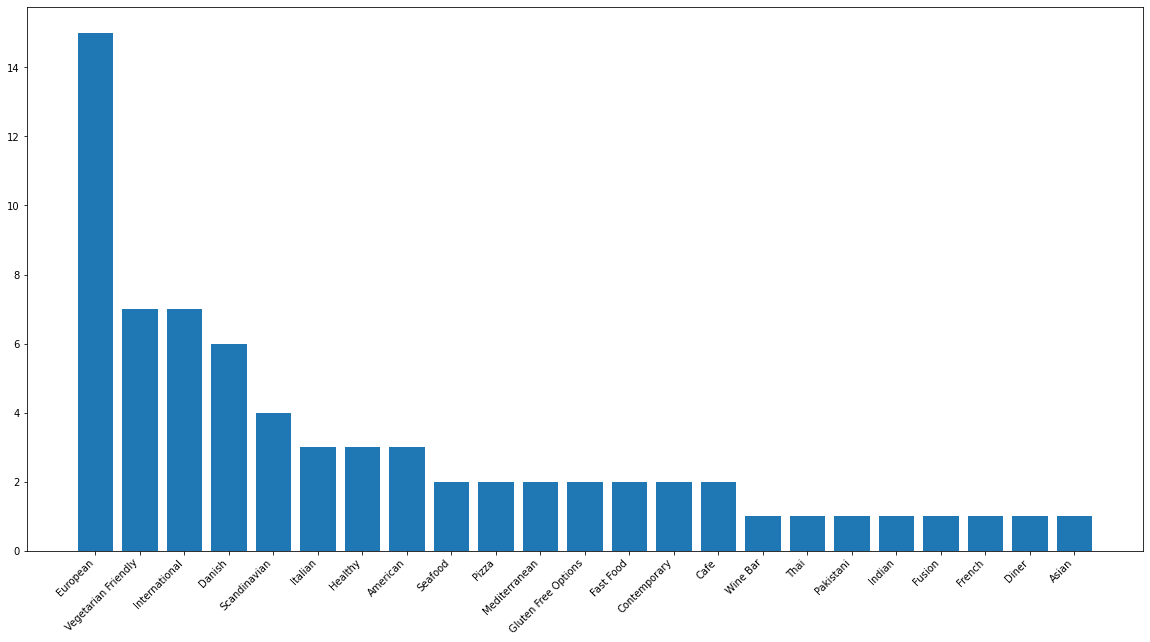

In [9]:
CousineTypeFlat = [y for x in restaurants.CousineType for y in x]

# https://stackoverflow.com/questions/49017002/bar-plot-based-on-list-of-string-values
keys, counts = np.unique(CousineTypeFlat, return_counts=True)

counts, keys = zip(*sorted(zip(counts, keys), reverse=True))

plt.figure(figsize=(20,10))
plt.bar(keys, counts)
plt.xticks(rotation=45, ha='right')
plt.show()

In [10]:
# https://georgetsilva.github.io/posts/mapping-points-with-folium/
locations = restaurants[['lat', 'lon']]
locationlist = locations.values.tolist()

map = folium.Map(location=[55.7, 12.6], zoom_start=12)
for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=restaurants['storeName'][point]).add_to(map)
map

<a id="reviews"></a>
## 3.2 Reviews


In [14]:
# Generate a profile for the dataset and display it
reviews_profile = ProfileReport(reviews, title="Reviews dataset", html={'style': {'full_width': True}});
reviews_profile.to_notebook_iframe();

<a id='businessquestions'></a>
# 4. Business Questions
